# Project Shop Talk

## Goal:

* Find the key drivers of profit.

# <div class="alert alert-block alert-info"> Imports

In [1]:
#my modules
import wrangle as wr
import explore as ex
import stats_conclude as sc
import evaluate as ev
import os

#numbers
import pandas as pd
import numpy as np
from scipy import stats

#vizzes
import matplotlib.pyplot as plt
import seaborn as sns

#prepare
from datetime import datetime
from sklearn.model_selection import train_test_split

#modeling
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score

#default in case I missed one somewhere along the line
np.random.seed(123)

#warnings ignore
import warnings
warnings.filterwarnings("ignore")

Imports Loaded Successfully


# <div class="alert alert-block alert-info"> Wrangle

## Acquire
* Data acquired from Jeff's local machine, emailed to me
* Each row represents a customer's visit
* Each column represents a feature of the shop's business
  
## Prepare
* Dropped negative index rows
* Changed date to datetime type
* Changed numeric columns to floats, round to 2
* Feature engineereed columns: Profit Per Part, Profit Per Labor, Profit
* Binned to create order sizes: Small, Medium, Large [0, 150, 750, 2000]
* Dropped columns:
    * sublet_cost, sublet_sale, sale_total, total_cost, percent_profit, amount_profit
* nulls and NaN's - dropped from labor_cost and feature engineered columns
* Outliers removed: Anything greater than 2000 were dropped
        * Point was to "zoom" in on average, everyday business to gather actionable insights 

## Data Dictionary  

| Feature | Definition|
|:--------|:-----------|
|date| Date of Transaction|   
|customer| Customer Name|
|parts_cost| Cost to Shop to Order Part|       
|labor_cost| Cost to Shop to Payout Labor|              
|total_cost| Parts + Labor Cost to Shop|       
|parts_sale| Profit to Shop Selling Part|
|labor_sale| Profit to Shop Charging Labor|   
|sale_total| Parts + Labor Profit to Shop|
|profit_per_part| Profit Per Part Per Job|
|profit_per_labor| Profit Per Labor Per Job|
|profit| Sale Total - Total Cost|

## Invoice Profit Summary
---
* 10880 rows × 12 columns **before** cleaning
* 6412 rows × 10 columns **after** cleaning
    * 59% Original Remaining
---
**Cost**: Shop **Credit**

**Sale**: Shop **Debit**

In [2]:
# get data
dfi = wr.get_data('invoice_profit_summ')
dfi

CSV File Found, Loading...


,date,customer,percent_profit,amount_profit,parts_cost,labor_cost,sublet_cost,total_cost,parts_sale,labor_sale,sublet_sale,sale_total
invoice,,,,,,,,,,,,
-1,4/1/14,"Owens, Bob",96.9,247.1,7.79,0,0,7.79,17.89,237,0,254.89
0,4/1/14,"Poole, Bill",100,150.1,0,0,0,0,0,150.1,0,150.1
1,4/2/14,"Williams, Arlene",76,173.36,54.86,0,0,54.86,109.72,118.5,0,228.22
2,4/1/14,"Higgins, Ryan",65.5,33.34,17.59,0,0,17.59,27.22,23.7,0,50.92
3,4/2/14,Dept. of Corrections,55.8,199.88,158.02,0,0,158.02,239.4,118.5,0,357.9
...,...,...,...,...,...,...,...,...,...,...,...,...
11328,5/31/23,"Beck, Rich",60.7,411.86,140.9,125.89,0,266.79,257.45,421.2,0,678.65
11329,5/31/23,"Culbertson, Bill",62.9,45.12,26.62,0,0,26.62,40.74,31,0,71.74
11330,5/31/23,UTV,100,680,0,0,0,0,0,680,0,680


In [3]:
# clean the data
df = wr.prep_invoice(dfi)
df

DataFrame acquired, cleaning...

Dropped Negative Index Rows
Changed date to datetime type
Changed numeric columns to floats, round to 2
Feature Engineereed Columns: Profit Per Part, Profit Per Labor, Profit
Binned To Create Order Sizes: Small, Medium, Large - [0, 150, 750, 2000]
Dropped Sublet Columns, Derived Columns
Dropped NaN's and all 0's from labor cost

Outliers Removed: Percent Original Data Remaining: 59.0



,date,customer,parts_cost,labor_cost,parts_sale,labor_sale,profit_per_part,profit_per_labor,profit,profit_size
invoice,,,,,,,,,,
15,2014-04-16,Merchant Funeral Home,29.89,16.90,53.18,126.40,23.29,109.50,132.79,small
16,2014-04-16,Merchant Funeral Home,108.69,26.00,206.40,339.70,97.71,313.70,411.41,small
25,2014-04-18,"Anderson, Robert (Andy)",5.65,6.50,11.30,39.50,5.65,33.00,38.65,small
30,2014-04-14,"Snyder, Chuck",182.56,32.50,318.30,267.45,135.74,234.95,370.69,medium
32,2014-04-16,Merchant Funeral Home,17.65,5.20,29.86,31.60,12.21,26.40,38.61,small
...,...,...,...,...,...,...,...,...,...,...
11326,2023-05-31,"Bell, Chris",112.05,44.28,224.10,108.00,112.05,63.72,175.77,medium
11327,2023-05-31,"Ledgerwood, Tom",35.61,15.77,63.87,31.00,28.26,15.23,43.49,small
11328,2023-05-31,"Beck, Rich",140.90,125.89,257.45,421.20,116.55,295.31,411.86,medium


In [4]:
# checking function worked 
df.dtypes

date                datetime64[ns]
customer                    object
parts_cost                 float64
labor_cost                 float64
parts_sale                 float64
labor_sale                 float64
profit_per_part            float64
profit_per_labor           float64
profit                     float64
profit_size               category
dtype: object

# <div class="alert alert-block alert-info"> Univariate Exploration

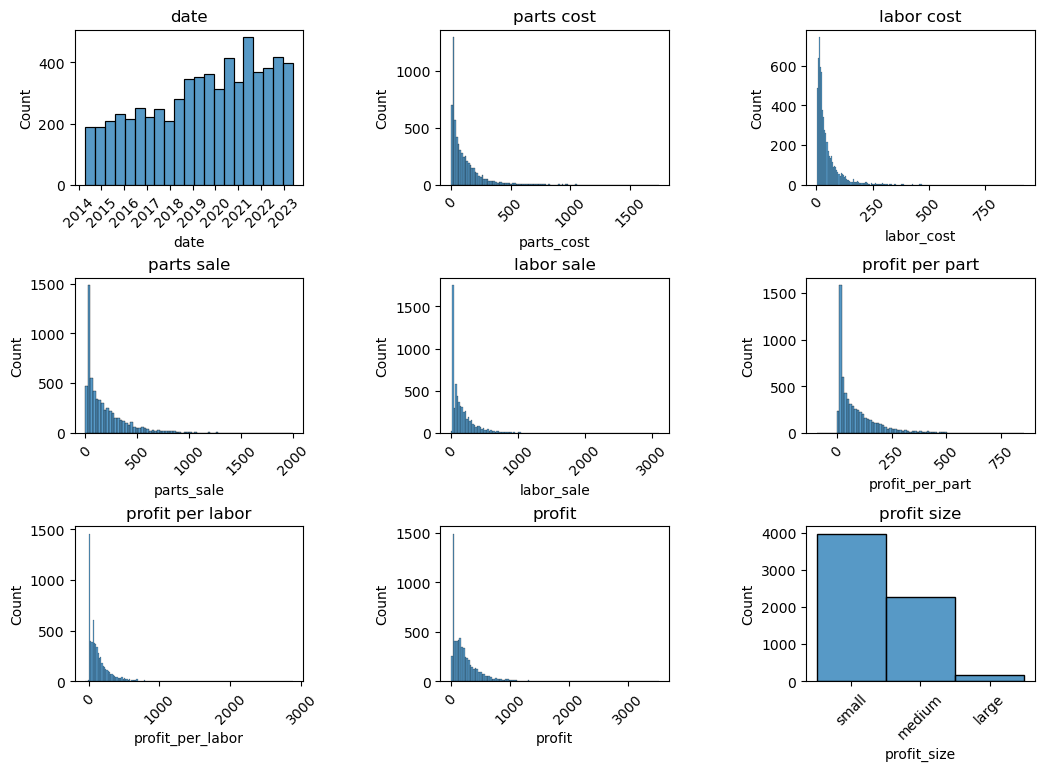

In [5]:
ex.univariate_hist(df.drop(columns={'customer'}))

In [6]:
ex.univariate_desc(df)

count                    6412
unique                   2120
top       2020-06-12 00:00:00
freq                       11
first     2014-04-14 00:00:00
last      2023-05-31 00:00:00
Name: date, dtype: object


count                          6412
unique                         1827
top       H&H BUSINESS SYSTEMS, INC
freq                            122
Name: customer, dtype: object


count    6412.000000
mean      118.174813
std       151.868288
min         0.000000
25%        21.850000
50%        65.375000
75%       155.455000
max      1740.810000
Name: parts_cost, dtype: float64


count    6412.000000
mean       48.332789
std        60.828148
min         1.030000
25%        13.530000
50%        27.970000
75%        58.802500
max       924.120000
Name: labor_cost, dtype: float64


count    6412.000000
mean      212.561833
std       253.548008
min         1.250000
25%        41.505000
50%       123.810000
75%       281.487500
max      1999.640000
Name: parts_sale, dtype: float64


count  

# <div class="alert alert-block alert-info"> Train, Validate, Test

* Encode for Categorical
* Split

In [7]:
# encode
df_encoded = ex.encode_classification(df)

In [8]:
# for classification
train_c, validate_c, test_c = ex.split_classification(df_encoded, 'profit_size')

Prepared DF: (6412, 12)
Train: (3846, 12)
Validate: (1283, 12)
Test: (1283, 12)


In [9]:
# for regression
train_r, validate_r, test_r = ex.split_regression(df)

Prepared DF: (6412, 10)
Train: (3846, 7)
Validate: (1283, 7)
Test: (1283, 7)


# <div class="alert alert-block alert-info"> Scaled

* MinMaxScaler used

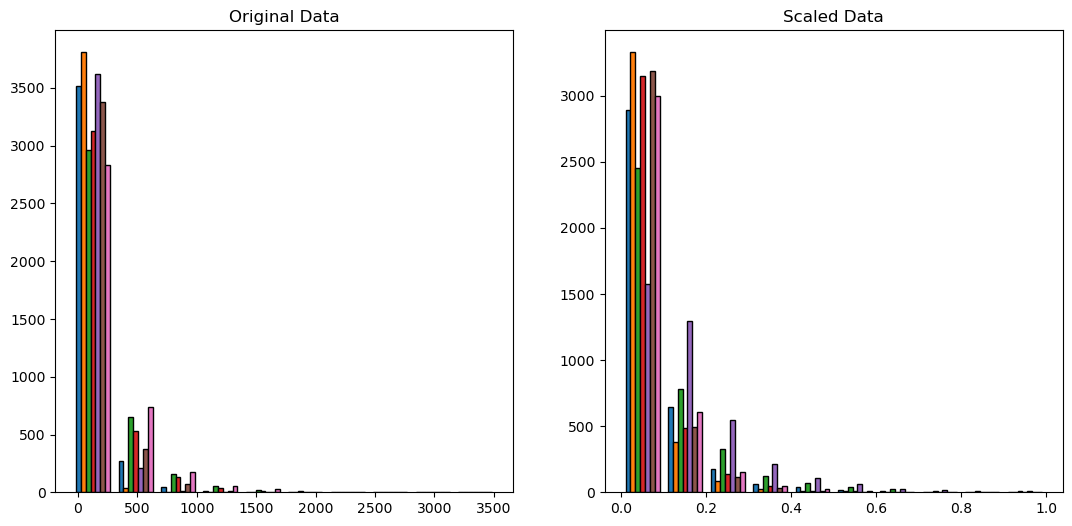

In [10]:
train_r_scaled, validate_r_scaled, test_r_scaled = ex.minmax_scaler\
(train_r, validate_r, test_r)

# <div class="alert alert-block alert-info"> Multivariate Exploration
---

**Questions**
1. Are the means of labor cost and profit the same?
2. Are the means of labor cost and profit the same controlling for profit size?
    * Diving deeper from the previous question
3. Are the means of parts cost and profit the same?
4. Are the means between parts cost and profit the same controlling for profit size?
    * Diving deeper from the previous question

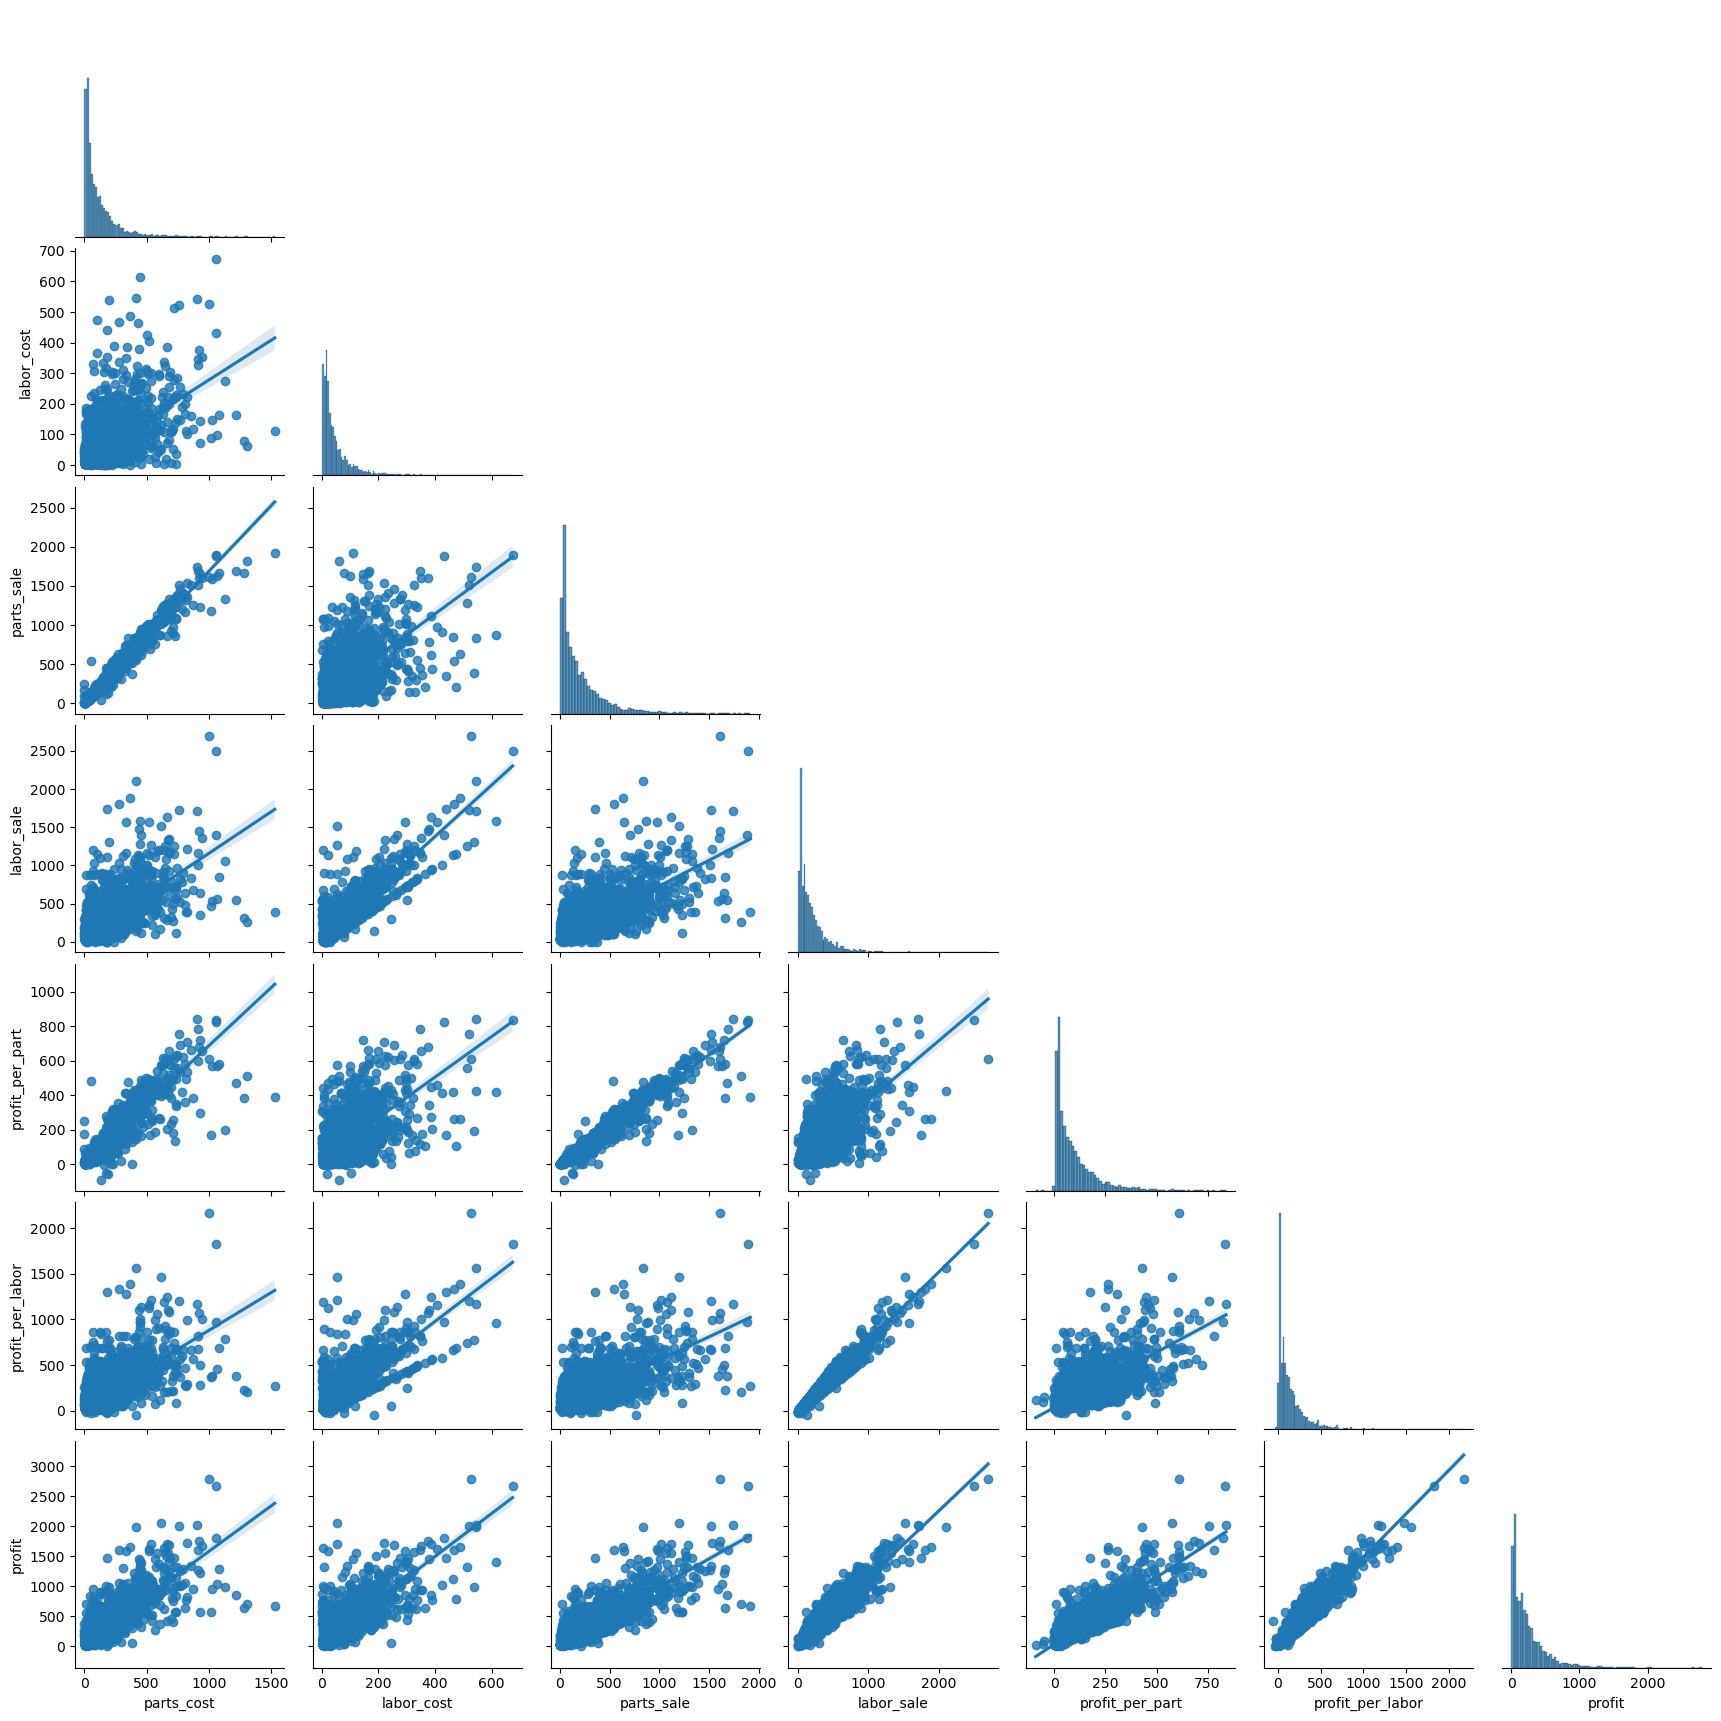

In [11]:
# overview of all columns
sns.pairplot(data=train_c.drop(columns={'profit_size_medium','profit_size_large'}),corner=True, kind='reg')
plt.show()

## 1. Are the means of labor cost and profit the same?

$H_0$: The means are the same

$H_a$: The means are not the same

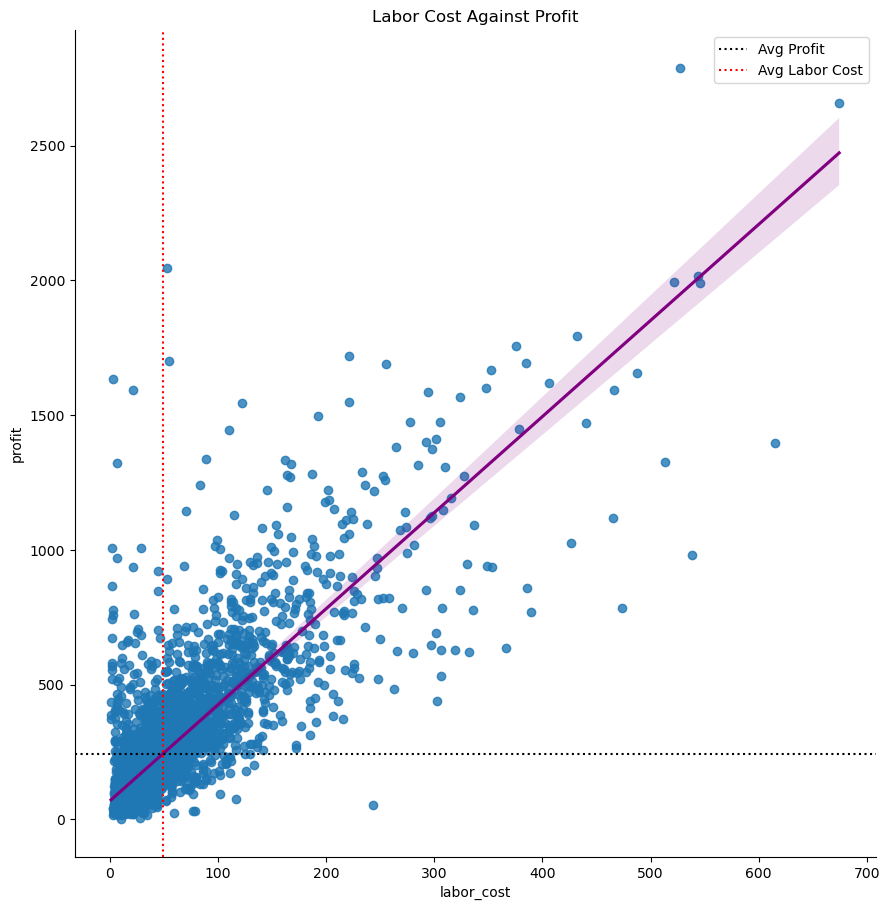

In [12]:
sns.lmplot(data=train_c, x='labor_cost', y='profit', sharex=True, sharey=True, size=9, line_kws={'color':'purple'})
plt.axhline(train_c.profit.mean(), color='black', linestyle=':', label='Avg Profit')
plt.axvline(train_c.labor_cost.mean(), color='red', linestyle=':', label='Avg Labor Cost')
plt.title('Labor Cost Against Profit')
plt.legend();

In [13]:
# shapiro test
sc.shapiro_test(train_c.labor_cost)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [14]:
# shapiro test
sc.shapiro_test(train_c.profit)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [15]:
# not normal, using spearmans for two continous variables
sc.conclude_spearmanr(train_c.labor_cost, train_c.profit)

Non-Parametric data: Spearman's R test successful...
r (correlation value): 0.8131040285876538
p-value: 0.0000000000 < 0.05?
----
We can reject the null hypothesis.


## 2. Are the means of labor cost and profit the same controlling for profit size?

$H_0$: The means are equal

$H_a$: The means are not equal

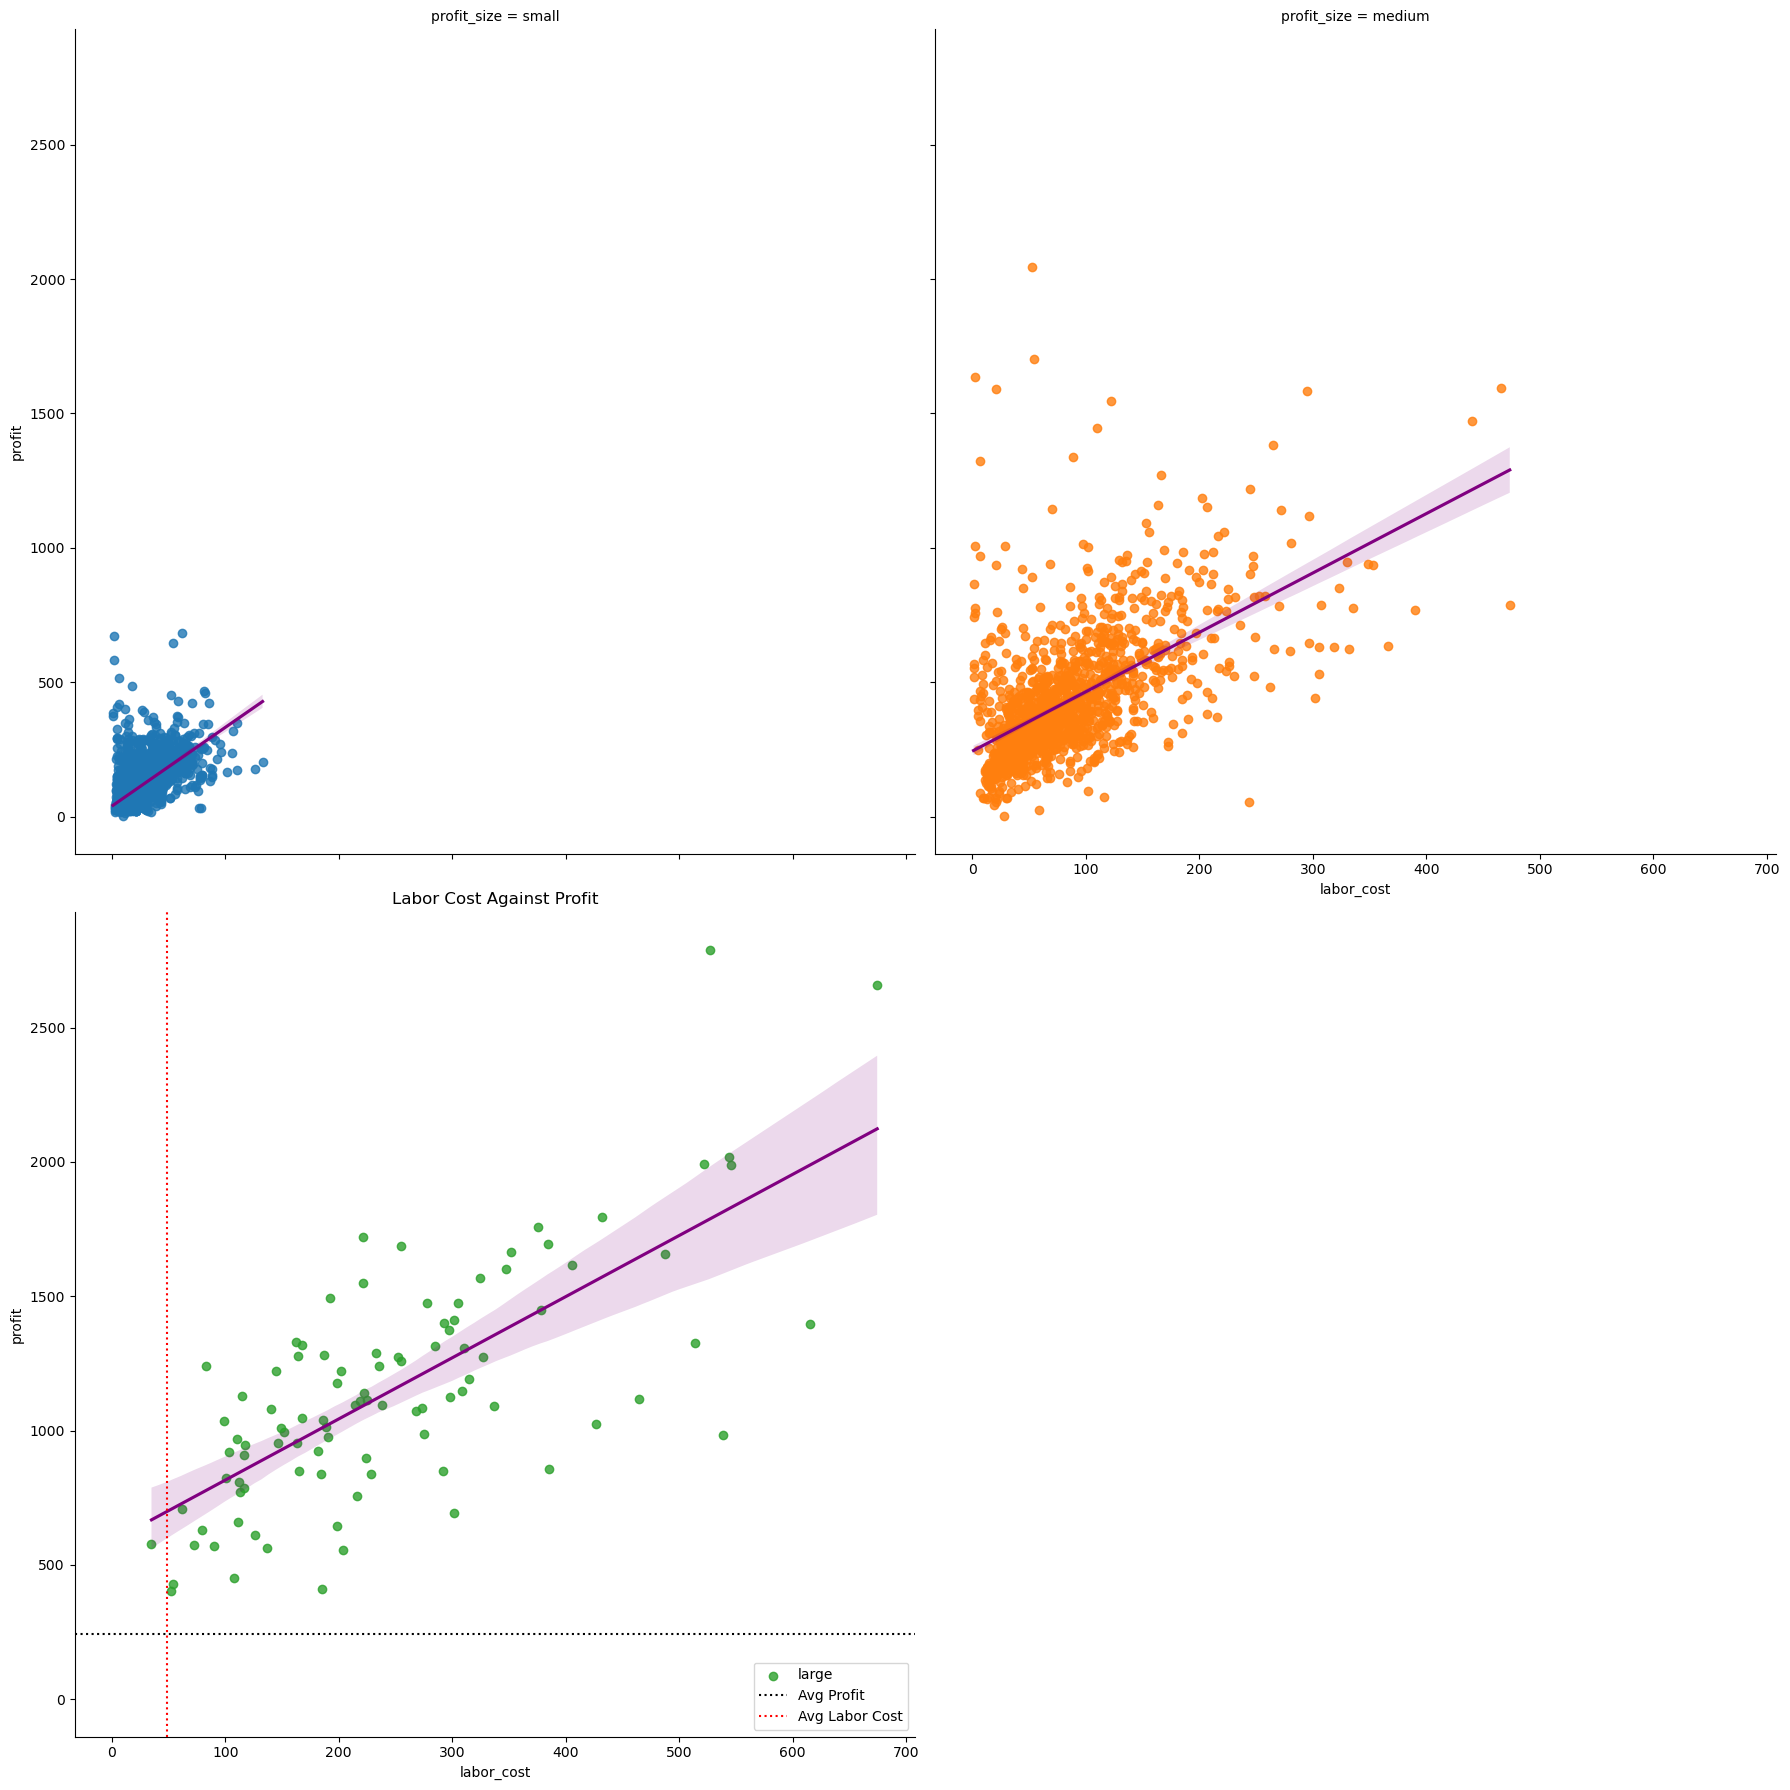

In [16]:
sns.lmplot(data=train_c, x='labor_cost', y='profit', hue='profit_size', sharex=True, sharey=True, size=9, line_kws={'color':'purple'}, col='profit_size'\
          ,col_wrap=2)
plt.axhline(train_c.profit.mean(), color='black', linestyle=':', label='Avg Profit')
plt.axvline(train_c.labor_cost.mean(), color='red', linestyle=':', label='Avg Labor Cost')
plt.title('Labor Cost Against Profit')
plt.legend();

In [17]:
# shapiro test
sc.shapiro_test(train_c.labor_cost)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [18]:
# shapiro test
sc.shapiro_test(train_c.profit)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [19]:
# not normal, using spearmans for two continous variables
sc.conclude_spearmanr(train_c.labor_cost, train_c.profit)

Non-Parametric data: Spearman's R test successful...
r (correlation value): 0.8131040285876538
p-value: 0.0000000000 < 0.05?
----
We can reject the null hypothesis.


## 3. Are the means of parts cost and profit the same?

$H_0$: The means are the same

$H_a$: The means are not the same

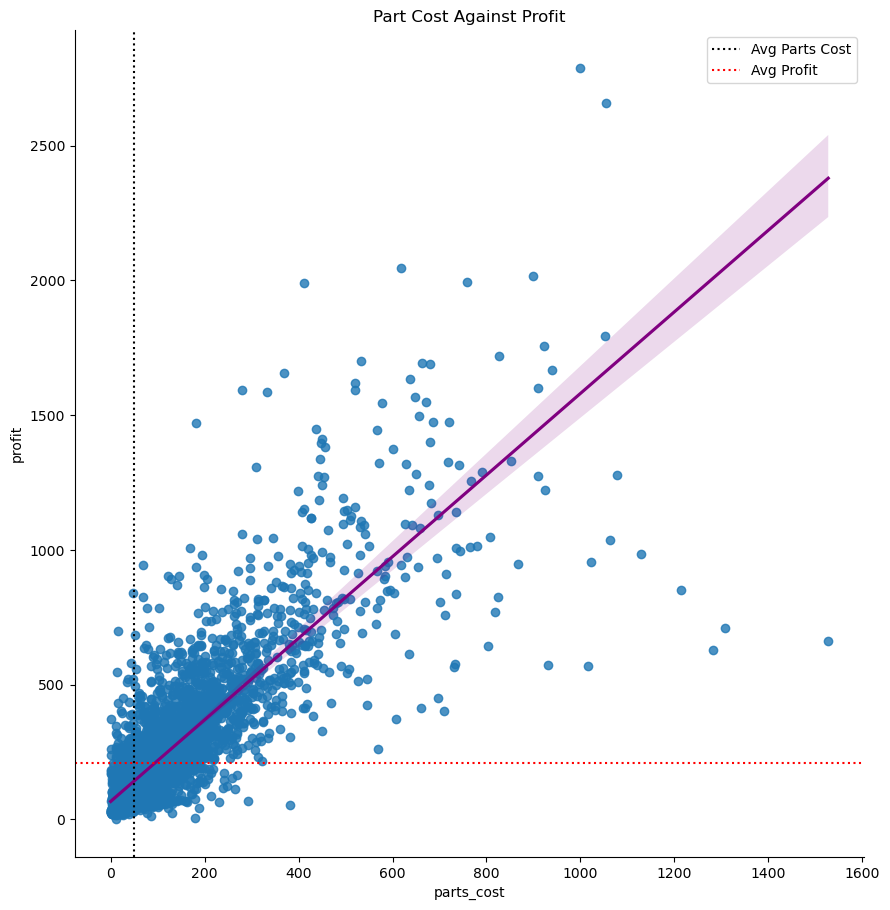

In [20]:
sns.lmplot(data=train_c, x='parts_cost', y='profit', sharex=True, sharey=True, size=9, line_kws={'color':'purple'})
plt.axvline(train_c.labor_cost.mean(), color='black', linestyle=':', label='Avg Parts Cost')
plt.axhline(train_c.parts_sale.mean(), color='red', linestyle=':', label='Avg Profit')
plt.title('Part Cost Against Profit')
plt.legend();

In [21]:
# shapiro test
sc.shapiro_test(train_c.parts_cost)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [22]:
# shapiro test
sc.shapiro_test(train_c.profit)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [23]:
# not normal, using spearmans for two continous variables
sc.conclude_spearmanr(train_c.parts_cost, train_c.profit)

Non-Parametric data: Spearman's R test successful...
r (correlation value): 0.8493038409483782
p-value: 0.0000000000 < 0.05?
----
We can reject the null hypothesis.


## 4. Are the means between parts cost and profit the same controlling for profit size?

$H_0$: The means are equal

$H_a$: The means are not equal

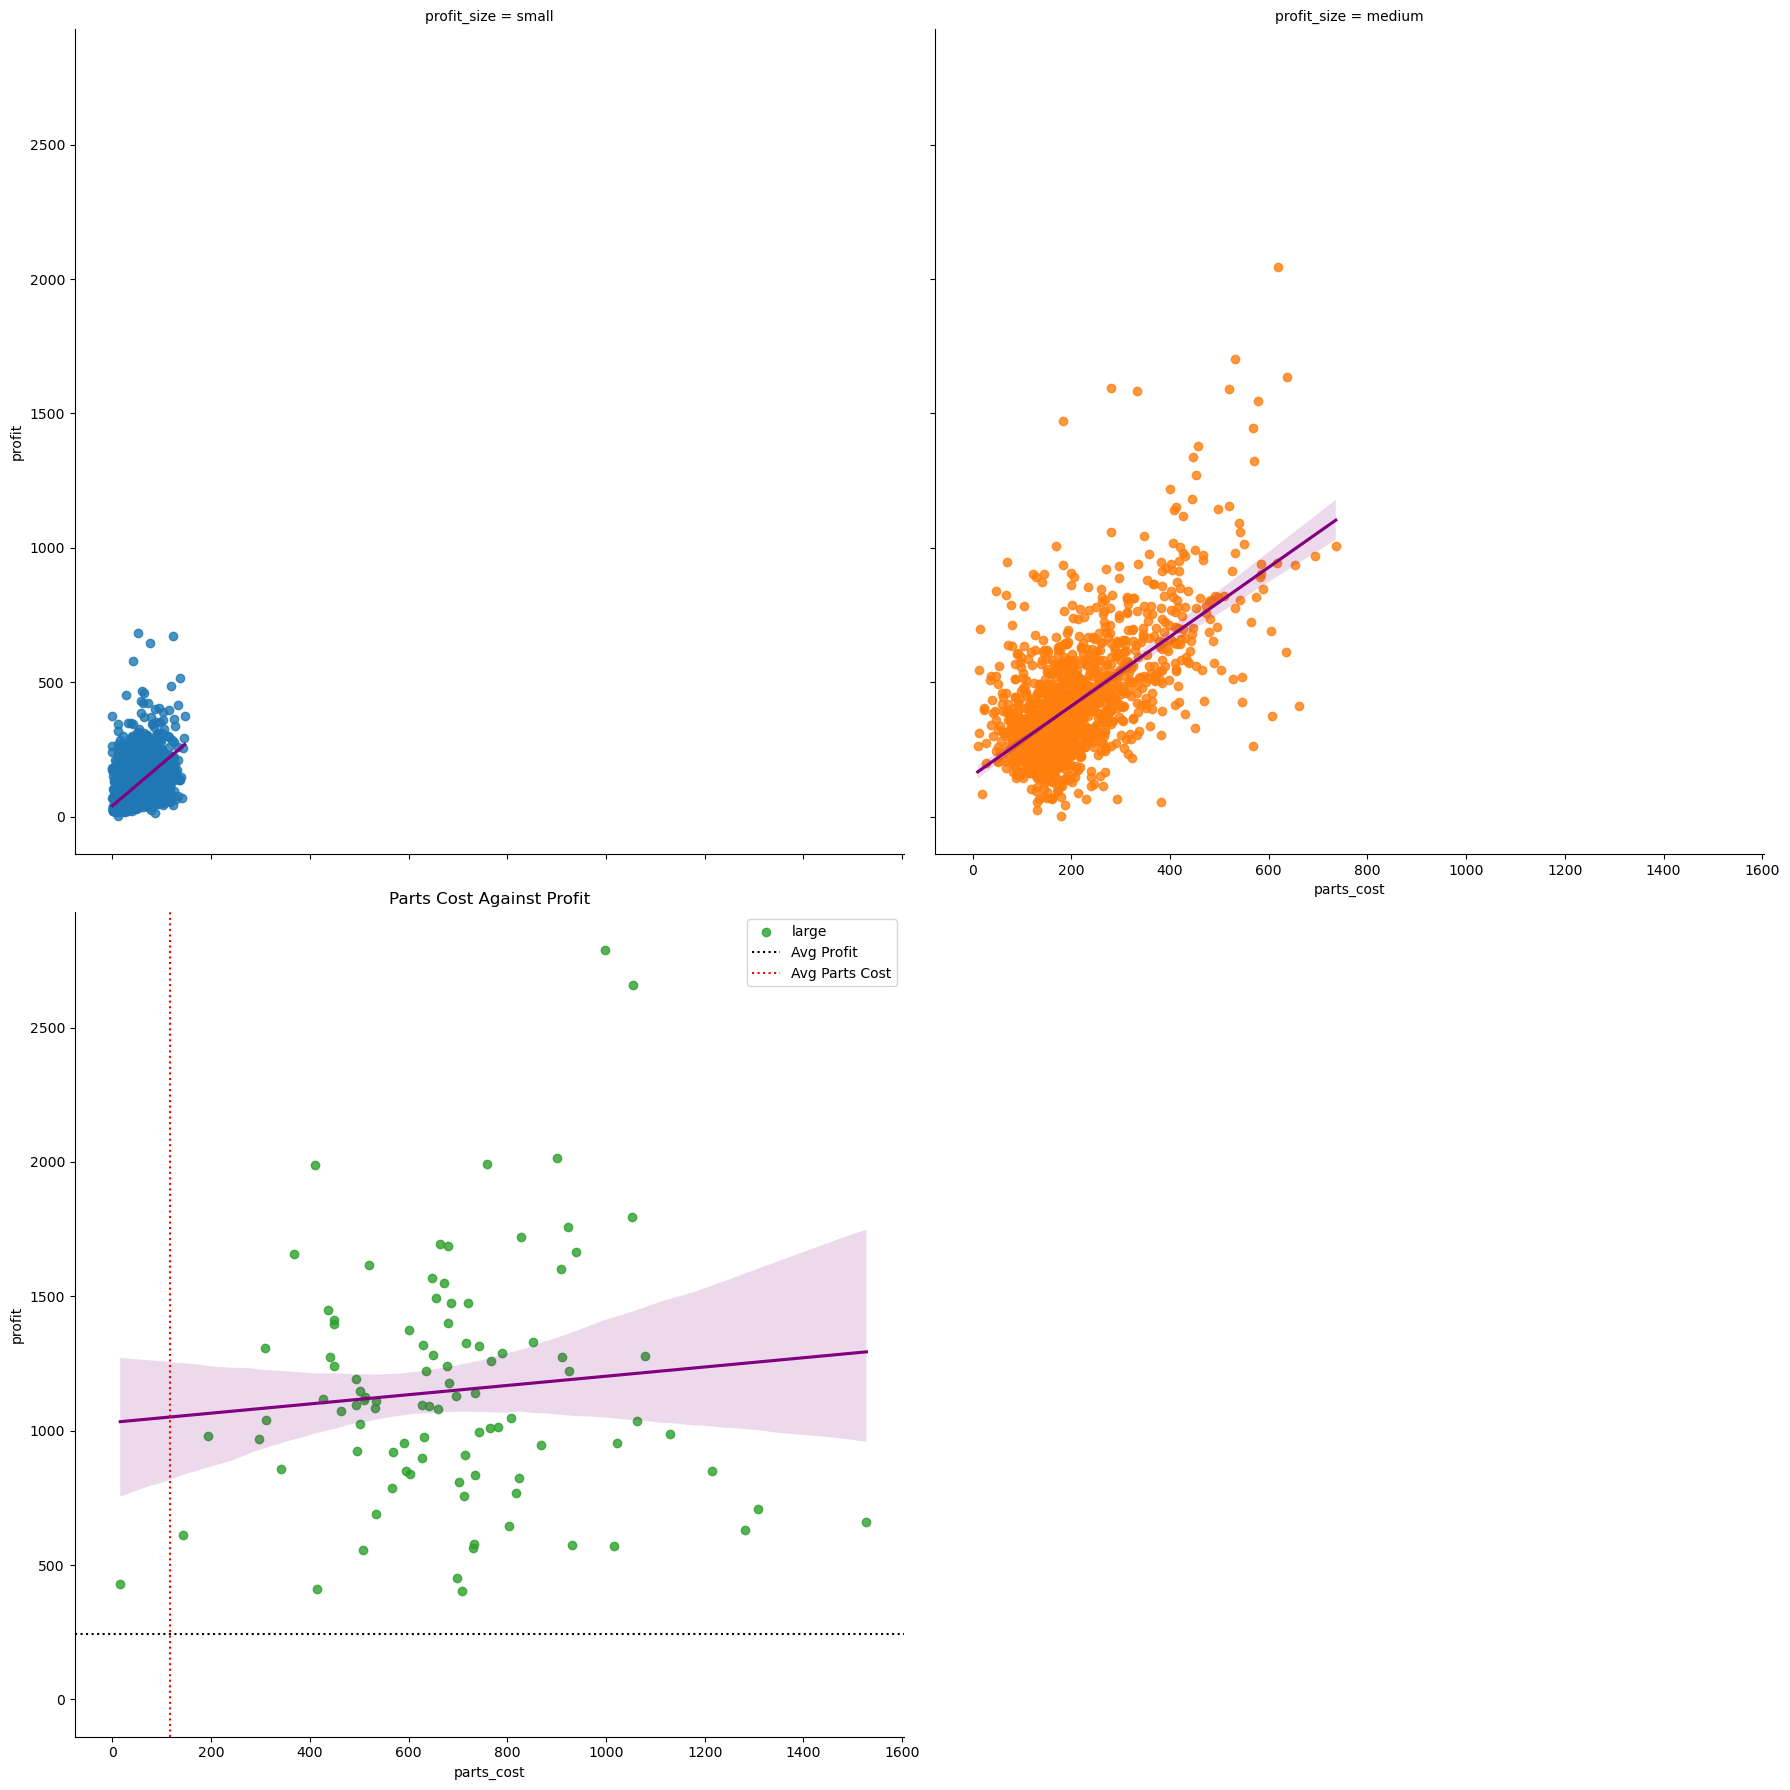

In [24]:
sns.lmplot(data=train_c, x='parts_cost', y='profit', hue='profit_size', sharex=True, sharey=True, size=9, line_kws={'color':'purple'}, col='profit_size'\
          ,col_wrap=2)
plt.axhline(train_c.profit.mean(), color='black', linestyle=':', label='Avg Profit')
plt.axvline(train_c.parts_cost.mean(), color='red', linestyle=':', label='Avg Parts Cost')
plt.title('Parts Cost Against Profit')
plt.legend();

In [25]:
# shapiro test
sc.shapiro_test(train_c.parts_cost)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [26]:
# shapiro test
sc.shapiro_test(train_c.profit)

p-value = 0.0000000000 < 0.05
----
Not Normal Distribution


In [27]:
# not normal, using spearmans for two continous variables
sc.conclude_spearmanr(train_c.parts_cost, train_c.profit)

Non-Parametric data: Spearman's R test successful...
r (correlation value): 0.8493038409483782
p-value: 0.0000000000 < 0.05?
----
We can reject the null hypothesis.


# Exploration Takeaways:

1. Null was rejected. The means of labor cost and profit are not the same. I notice the confidence interval flares at the tip indicating there is a variance occuring there. The average cost for labor and the average profit leaves room for improvement. On the smaller scale, it seems to be relatively healthy. The higher the profit goes, the mean of labor cost stays relatively low indicating a healthy relationship between cost for the shop to employ techs and the profit to be made.
> * 81% correaltion<br>

2. Null was rejected. I dove deeper into the first question here, controlling for profit size. Overall, the smaller jobs trend positive, the medium jobs do not trend as positive. I would like to see as costs go up the profit would go up more than it does. It kind of clumps around 100 dollars for labor cost and 250 dollars for profits which matches the business knowledge given to me by the owner of a labor charge of 108/hr and the mean profit here being 244. The larger jobs have almost flatlined with no confidence for prediction at all. There is lots of variance here. The focus here is on labor cost to profit.
> * 81% correlation<br>

3. Null was rejected. Based on the graph I can see that there is some amount of variation causing some interesting spread. The confidence intervals vary widely indicating a greater amount of distance between points as they get larger. This is interesting, the next question I dove a little deeper into the possible 'why' behind this happening.
> * 85% correlation<br>

4. Null was rejected. Diving deeper into question three and controlling for profit size. The smaller jobs tend to be trending excellent, the medium size jobs have increased variation with a decrease in positive trendline, the large jobs have almost completely flatlined. This was an interesting find. The focus here is on parts cost to profit.
> * 85% correlation<br>

---

***Overall Takeaways:***
From all three iterations, this being the final, I noticed a trend of undercharging for parts and labor. From iterations one and two, I discovered that average part sales are 9.54 too low (iteration one) and that labor charges are 15.23 too low (iteration two).
    * I got to these numbers by taking the averages between iterations given different scenarios. The industry markup average is 100% for parts sales and other shops in the valley charge closer to 130 per labor hour.
    
- Of note: parts cost after ~$1,100 saw a significant drop in parts sale, almost like someone is a good guy and giving out discounts... :)

# <div class="alert alert-block alert-info"> X_train, y_train, X_validate, y_validate, X_test, y_test

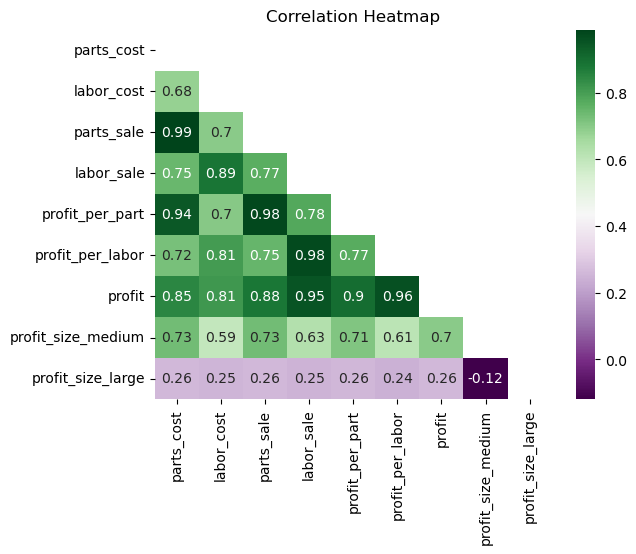

In [28]:
# correlation factors
ex.plot_heatmap(train_c)

In [29]:
# assigning variables for classification - stratified
X_train, X_validate, X_test, y_train, y_validate, y_test = ex.assign_variables(\
        train_c.drop(columns={'date','customer','profit_per_part','profit_per_labor','profit'}),\
        validate_c.drop(columns={'date','customer','profit_per_part','profit_per_labor','profit'}),\
        test_c.drop(columns={'date','customer','profit_per_part','profit_per_labor','profit'}), 'profit_size')
X_train.head(1)

,parts_cost,labor_cost,parts_sale,labor_sale,profit_size_medium,profit_size_large
invoice,,,,,,
3167,325.39,68.88,736.46,357.0,1,0


In [30]:
# assigning variables for regression modeling - not stratified
X_train_r, X_validate_r, X_test_r, y_train_r, y_validate_r, y_test_r = \
ex.assign_reg_variables(train_r.drop(columns={'profit_per_part','profit_per_labor'})\
                     , validate_r.drop(columns={'profit_per_part','profit_per_labor'})\

                     , test_r.drop(columns={'profit_per_part','profit_per_labor'}), 'profit')

In [31]:
# baseline accuracy for classification
baseline_accuracy = ev.baseline_classification(train_c)
baseline_accuracy

The baseline accuracy is 62.0%


0.6206448257930317

# <div class="alert alert-block alert-info"> Feature Importance

## K Best: 2

In [32]:
# using select kbest to determine feature importance
kbest_results = ev.select_kbest(X_train_r, y_train_r, k=2)
kbest_results

,p_value,feature_score
labor_sale,0.0,44468.986632
parts_sale,0.0,11199.603714


In [33]:
# results to df to see actual values
X_train_KBtransformed = ev.kbest_to_df(X_train_r, y_train_r, 2)
X_train_KBtransformed

,parts_sale,labor_sale
invoice,,
3289,30.72,34.0
4970,197.78,191.4


## RFE

In [34]:
# The top two features
all_rankings = ev.rfe(X_train_r, y_train_r, 2)
all_rankings.head(2)

,rfe_ranking
labor_cost,1
labor_sale,1


# <div class="alert alert-block alert-info"> Modeling

* Classification
    * Accuracy is the metric
    * Target is profit_size
    
* Regression
    * RMSE and R2 are the metrics
    * Target is profit
    
---
**Features to send in:**<br>
Classification:
* labor_cost
* labor_sale
* parts_sale
* parts_cost

Regression:
* labor_cost
* labor_sale
* parts_sale
* parts_cost

***Dropped profit_per_part and profit_per_labor features used for exploration***

**Models Selected:**<br>

Classification:
* KNN
* Decision Tree
* Random Forest
* Logisitic Regression

Regression:
* OLS_1 (Linear Regression)
* LassoLars
* Tweedie (GLM)


## Classification

* KNN
* Decision Tree
* Random Forest
* Logisitic Regression

DECISION TREE
For depth of 1, the accuracy is 0.91
For depth of 2, the accuracy is 0.95
The baseline accuracy is 62.0


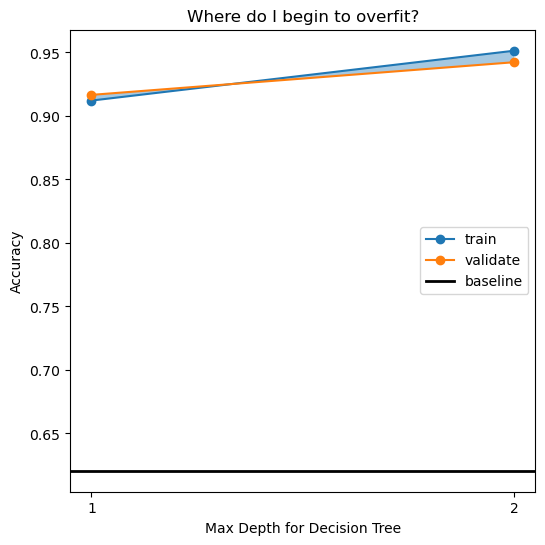

RANDOM FOREST
For depth of  1, the accuracy is 0.91
For depth of  2, the accuracy is 0.95
The baseline accuracy is 62.0


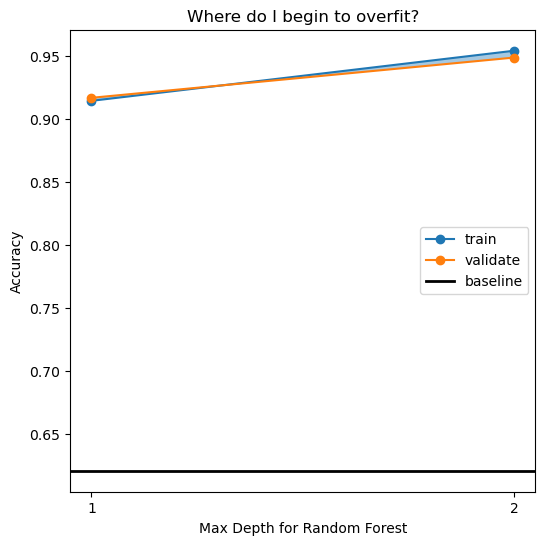

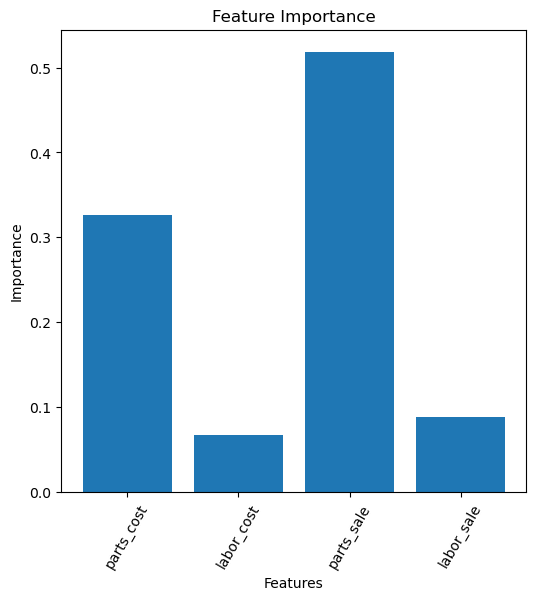

KNN
The number of features sent in : 4 and are ['parts_cost', 'labor_cost', 'parts_sale', 'labor_sale'].
15 is the number of neighbors that produces the best fit model.
The accuracy score for the train model is 0.96.
The accuracy score for the validate model is 0.97.
The baseline accuracy is 62.0


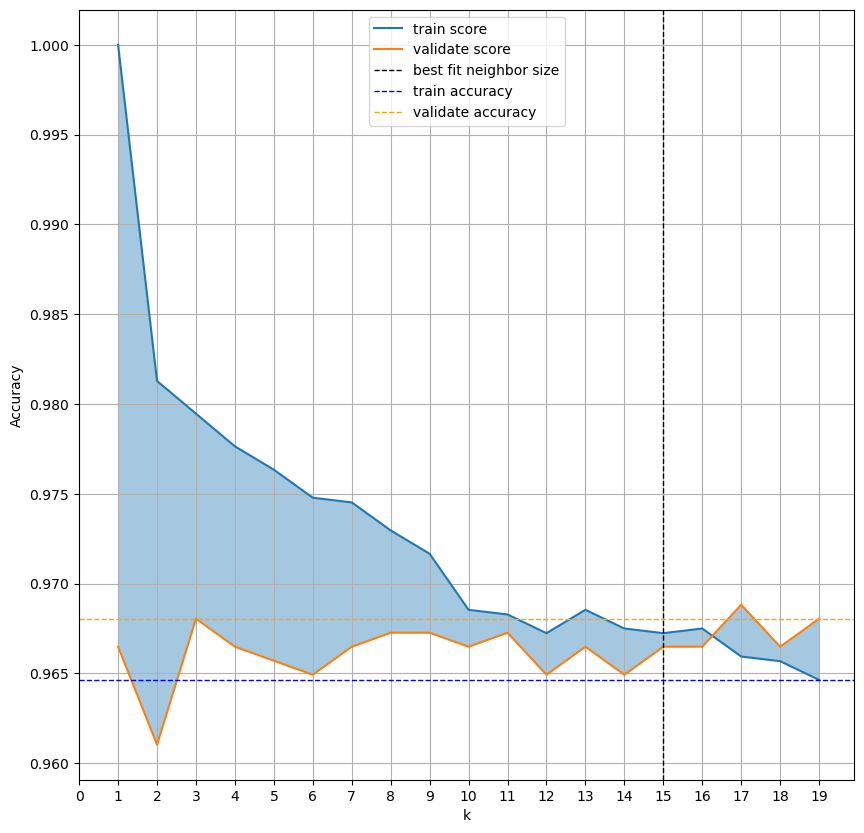

LOGISTIC REGRESSION
Train Dataset
The train model's accuracy is 0.98
The baseline accuracy is 62.0
              precision    recall  f1-score   support

       large       0.98      0.64      0.77        97
      medium       0.97      0.99      0.98      1362
       small       0.99      1.00      0.99      2387

    accuracy                           0.98      3846
   macro avg       0.98      0.87      0.92      3846
weighted avg       0.98      0.98      0.98      3846

LOGISTIC REGRESSION
Validate Dataset
The validate model's accuracy is 0.98
The baseline accuracy is 62.0
              precision    recall  f1-score   support

       large       0.89      0.53      0.67        32
      medium       0.96      0.98      0.97       454
       small       0.99      1.00      0.99       797

    accuracy                           0.98      1283
   macro avg       0.95      0.84      0.88      1283
weighted avg       0.98      0.98      0.98      1283



In [35]:
# run all 4 classification models and return df with scores
ev.all_4_classifiers(X_train.drop(columns={'profit_size_medium','profit_size_large'}), \
    y_train, X_validate.drop(columns={'profit_size_medium','profit_size_large'}), y_validate, 20, baseline_accuracy)

## Classification Modeling Takeaways:
---
* Decision Tree, depth 1
    * 91% Train
    * 95% Validate
* Decision Tree, depth 2
    * 91% Train
    * 95* Validate
* Random Forest, depth 1
    * 91% Train
    * 95% Validate
* Random Forest, depth 2
    * 91% Train
    * 95% Validate
* KNN, 1
    * 96% Train
    * 97% Validate
* Logistic Regression
    * 98% Train
    * 98% Validate
---
***Overall Takeaways:***
Classification overfit on every model except for KNN possibly providing a decent outcome. If we go this route, would need to reintroduce more original data to possibly get a better fit with more than 3 bins.

## Regression

* OLS Linear Regression
* LassoLars
* Tweedie (GLM)

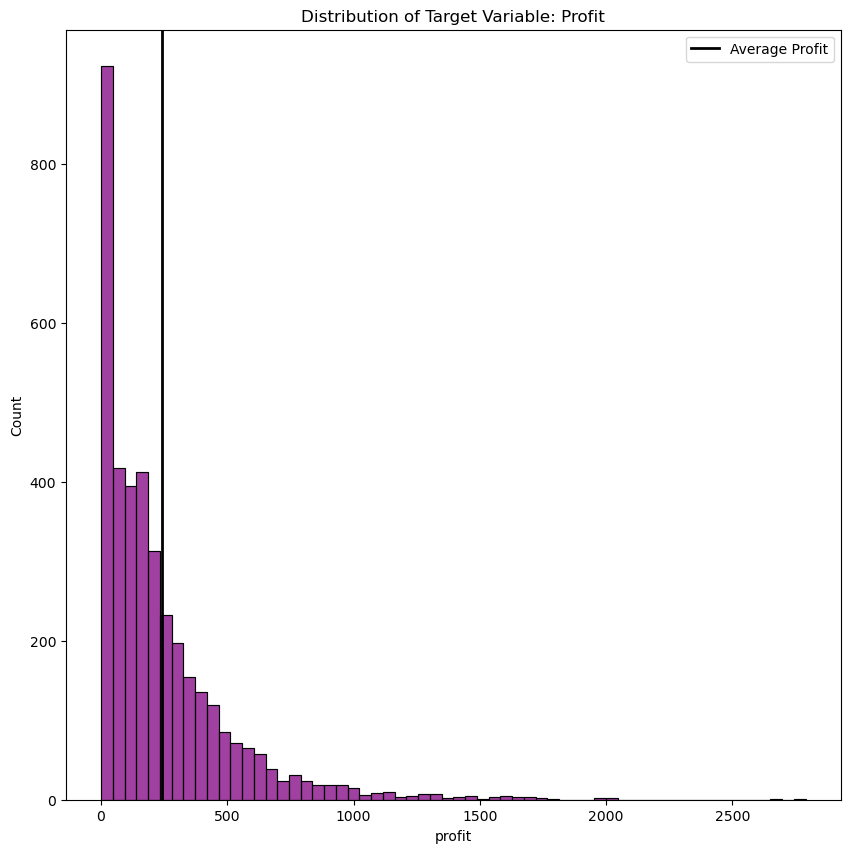

In [36]:
ev.plot_target(train_c, 'profit')

### OLS Standard

* OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

### LASSO + LARS

* LASSO = Least Absolute Shrinkage and Selection Operator
* LARS = Least Angle Regression

* Performs intrinsic feature selection and noise reduction to avoid overfitting
* The most important hyperparameter is alpha
    * alpha determines the degree of regularization applied to the model
    * The lowest alpha is zero, and this represents no regularization (identical to OLS)
    * There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    * Generally speaking, the higher the alpha, the lower your risk for overfitting
    * alpha = 1.0 is a good place to start

### GLM / Tweedie

* The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

* About power:
    * power = 0: Normal Distribution
    * power = 1: Poisson Distribution
    * power = (1,2): Compound Distribution
    * power = 2: Gamma Distribution
    * power = 3: Inverse Gaussian Distribution

Baseline Created
OLS Created...
Top Linear Regression Feature: ['labor_sale']
OLS: For every 1 dollar increase in Labor Sale, I predict a 1.13 dollar increase in Profit
LassoLars Created...
GLM Created...
Best Model: LassoLars
Proceed to Test


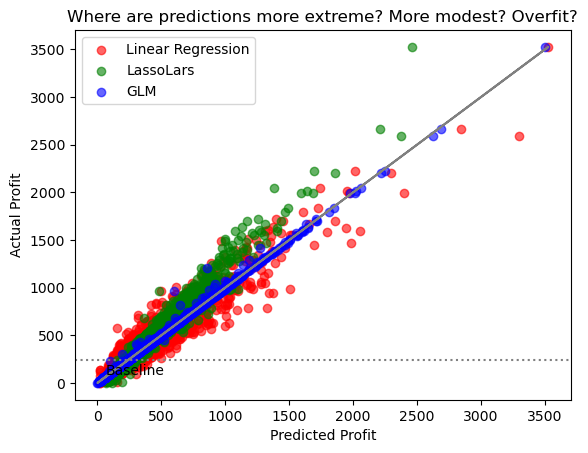

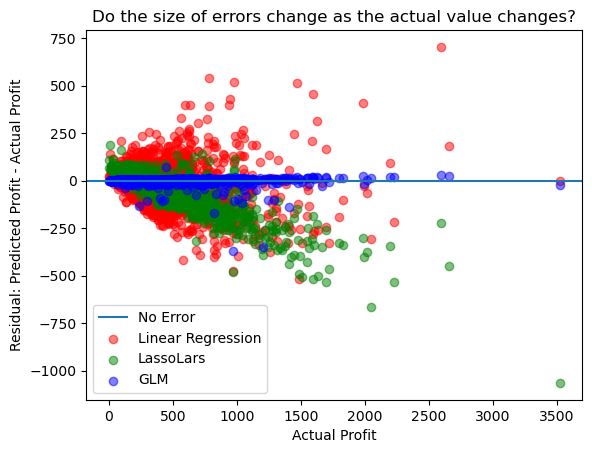

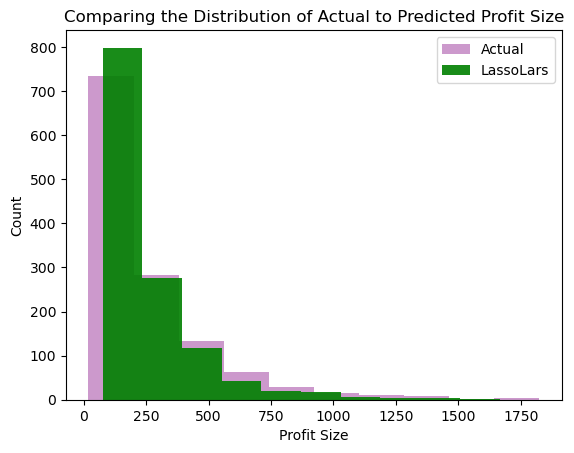

,model,rmse,r2
0,-baseline-,280.59,-0.000000
1,ols,72.53,0.911422
2,lars,65.29,0.928240
3,glm,12.74,0.997268
6,test-lars,70.42,0.928763


In [37]:
metrics_reg_df = ev.all_3_regression(X_train_r, y_train_r, X_validate_r, y_validate_r, X_test_r, y_test_r)
metrics_reg_df

## Regression Takeaways:
---
Big finding!
> **For every 1 dollar increase in Labor Sale, I predict a 1.13 dollar increase in Profit**

---

***Baseline RMSE: $280.59***
***Baseline R2:   0***

OLS Standard Linear Regression:
* $72.53
* .91   

LARS:
* $65.29
* .93

GLM:
* $12.74
* 100
---
***LassoLars Model selected to test over all models created***

Test Takeaways:

* LassoLars performed great on test! RMSE of 70.42 and an R2 of .93

# <div class="alert alert-block alert-info"> Summary
    

## Explore
    
***This is iteration 3, Insights contain some information from previous iterations, that information is contained in the initial explore notebook.***

Questions

1. Are the means of labor cost and profit the same?
2. Are the means of labor cost and profit the same controlling for profit size?
    * Diving deeper from the previous question
3. Are the means of parts cost and profit the same?
4. Are the means between parts cost and profit the same controlling for profit size?
    * Diving deeper from the previous question
    
Key Drivers:
* Labor Sale
* Parts Sale

Local Industry Info Found:
* Labor sale is below average
* Parts sale is low
---
    
## Modeling

* Classification
    * Accuracy is the metric
    * Target is profit_size
    
        ***Baseline: 62%***
    
    * KNN was the only model that did not overfit
    
* Regression
    * RMSE and R2 are the metrics
    * Target is profit
    
        ***Baseline: 280.59, 0***

**TEST LARS: $65.29, .93**
    
Big finding!
> **For every 1 dollar increase in Labor Sale, I predict a 1.13 dollar increase in Profit**
> **Parts Sale is 9.54 low, as well as Labor Sale is 15.23 low.**
---
    
### Recommendations and Next Steps
    
* For the data scientists: Add outliers back in to beef up the data set. I expect the model to perform well on future data and look forward to the next steps to provide that for the customer.
    
* For the business: Recommend waiting for next steps to be completed before increasing costs. The business is well in the green, it's safe to wait for additional analysis to be finished before raising costs.
    
### Next Steps:
    
* Perform time series analysis to provide predictions for profit gains if the shop were to act on the insights provided above.